In [ ]:
#Assingment set 2 Challenge 2

#Assumptions: 
#1 GW signals can produce only from equal mass binary systems with a range between 5 to 10
#2 We assume a threshold on matched filter SNR of 8 to claim detection of GW



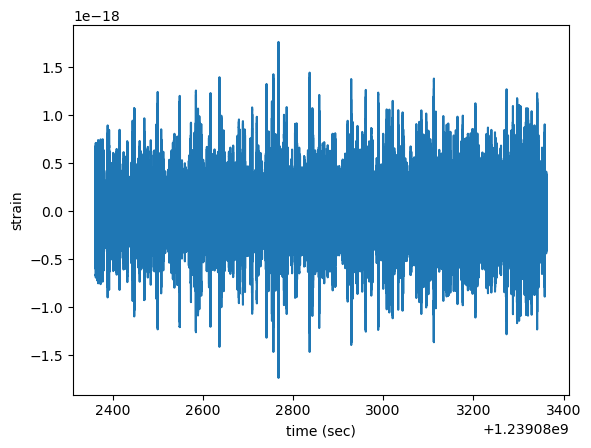

In [9]:
#importing data
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d

#plotting waveform
plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')

#stop warning
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

(1e-47, 1e-42)

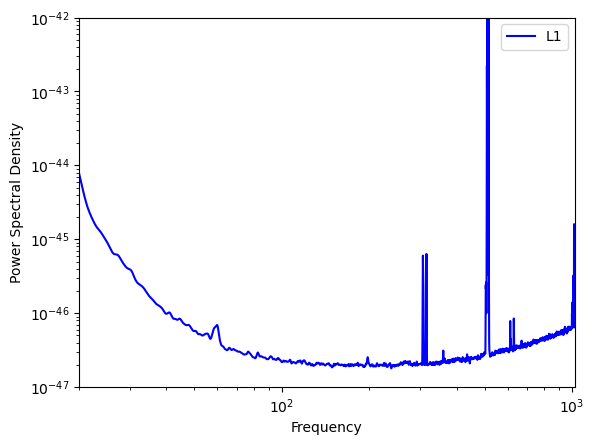

In [16]:
#plotting noise power spectral
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
import pylab

#frequency domain version of the data
fd = data.to_frequencyseries()
plt.plot(time, data, color='blue') 
plt.xlabel('time (sec)')
plt.ylabel('strain')

psd1 = interpolate(data.psd(2), fd.delta_f)
psd1 = inverse_spectrum_truncation(psd1, int(2*data.sample_rate), low_frequency_cutoff=15.0, trunc_method='hann')
pylab.loglog(psd1.sample_frequencies, psd1, label='L1', color='blue') 
pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
pylab.legend()

pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)


In [19]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
#estimate the power spectral density

psd = data.psd(4)

#interpolate psd to match our data
psd = interpolate(psd, data.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * data.sample_rate),low_frequency_cutoff=15)

Text(0, 0.5, 'Strain')

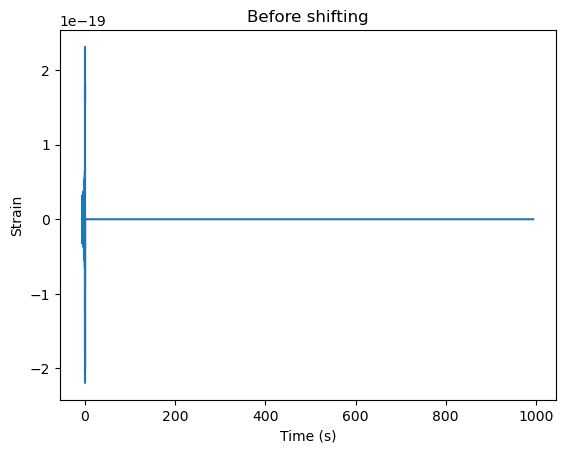

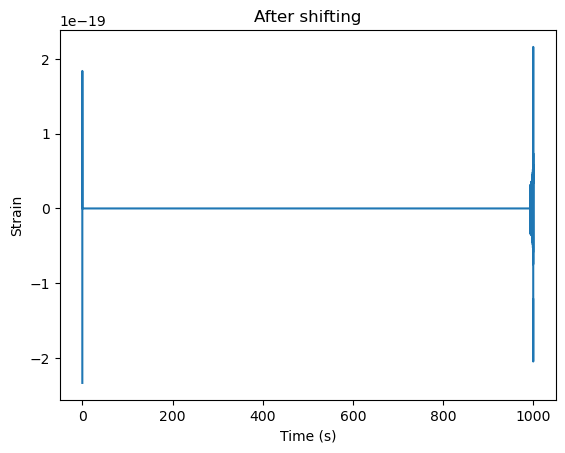

In [27]:
from pycbc.waveform import get_td_waveform

#we assume that GW signals can produce only from equal mass binary systems with a range between 5 to 10
m = 10 #solar masses

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=data.delta_t,
                     f_lower=20)

#resize the vector to match our data
hp.resize(len(data))

#plotting signal before and after shift
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

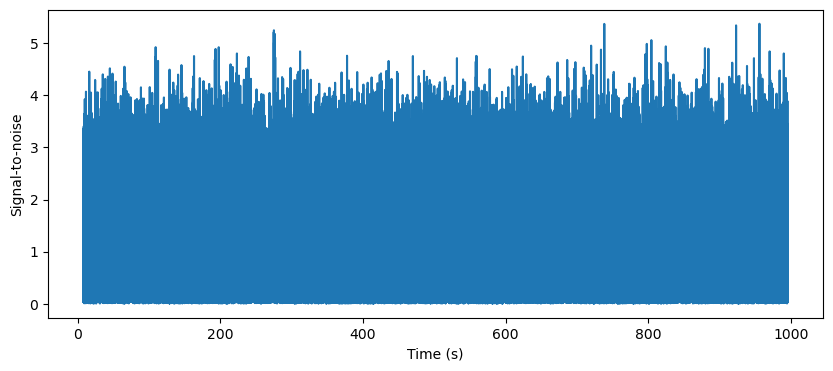

We found a signal at 956.027099609375s with SNR 5.372673849581942


In [28]:
from pycbc.filter import matched_filter
import numpy
#plotting snr of data
snr = matched_filter(template, data,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

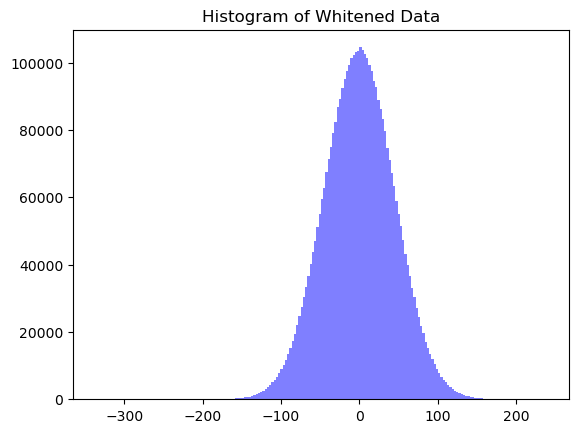

In [31]:
import pycbc.psd
#whitening data
white_data = (data.to_frequencyseries() / psd1**0.5).to_timeseries()
white_data=white_data.crop(5,5)
#histogram
unga = 200
n, bins, patches = plt.hist(white_data, unga, facecolor='blue', alpha=0.5)
plt.title("Histogram of Whitened Data")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

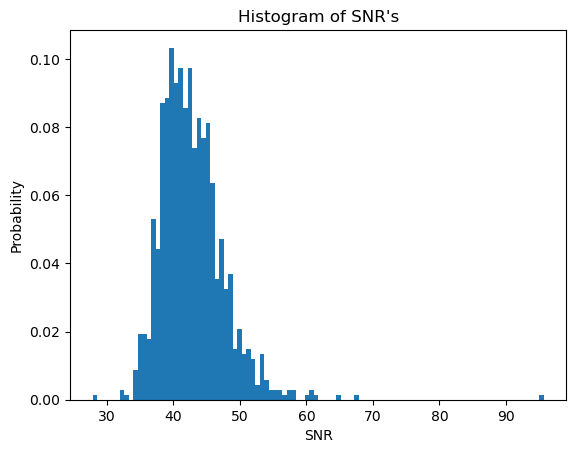

In [41]:
#generate Waveform
from pycbc.waveform import get_fd_waveform
f_final = 2048.0

# Generate frequency domain waveform
hp, hc = get_fd_waveform(approximant="TaylorF2", 
                          mass1=10, 
                          mass2=10, 
                          delta_f=1.0/200.0, 
                          distance=500,  
                          f_lower=20, 
                          f_final=2048)

#calculate PSD
psds = pycbc.psd.interpolate(pycbc.psd.welch(data), hp.delta_f)

#clculate SNR
snr = np.sqrt(pycbc.filter.sigmasq(hp, psds))

#parameters for data slicing
slices = 1000
data_slice_length = len(data) // slices

SNR_all = []
#iterate over each data slice
for i in range(slices):
    data_piece = data[i * data_slice_length: (i + 1) * data_slice_length]
    psds_piece = pycbc.psd.interpolate(pycbc.psd.welch(data_piece), hp.delta_f)
    SNR_piece = np.sqrt(pycbc.filter.sigmasq(hp, psds_piece))
    SNR_all.append(SNR_piece)

#histogram
plt.hist(SNR_all, 100, density=True)
plt.title("Histogram of SNR's")
plt.xlabel("SNR")
plt.ylabel("Probability")

plt.show